**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [1]:
import torch
%load_ext autoreload
%autoreload 2

from DrTorch.model_selection import grid_search_train_validation
from DrTorch.utilities import DataLoaderFromPipelineStrategy
from DrTorch.utilities import plot_history
from DrTorch.metrics import MultyHeadMetric, F1_Score, Accuracy, Recall, Precision
from DrTorch.callbacks import EarlyStopper
from DrTorch.wrappers import OptimizerWrapper,Criterion, MultyHeadCriterion

from sys import platform
from utilities import *
from IPython.display import display

import wandb
from functools import partial
import itertools

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier
from models.bertOne import BertOne


import warnings


warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
warnings.filterwarnings("ignore", message="overflow encountered in scalar add")

## Setting the device

In [2]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.1+cu121
Using device: cuda


In [3]:
if device == 'cuda':
    !nvidia-smi


## Defining flags and variables

In [4]:
##### PATHS AND DIRECTORY

DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

# Directory paths for model and result storage
BERT_DIRECTORY = "local-bert"
RESULT_DIRECTORY = 'results'     # Directory to store the results
GRID_DIRECTORY = 'grid'          # Directory to store the grid results
WEIGHTS_DIRECTORY = 'weights'    # Directory to store model weights

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 

# File paths for grid search results
FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'freezed_bertone_grid_search_results.pkl')
FULL_BERTONE_GRID_SEARCH_RESULTS_PATH = os.path.join(RESULT_DIRECTORY, GRID_DIRECTORY, 'full_bertwo_grid_search_results.pkl')

# File paths for model weights
FREEZED_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'freezed_bertone_weights.pth')
FULL_BERTONE_WEIGHTS_PATH = os.path.join(RESULT_DIRECTORY, WEIGHTS_DIRECTORY, 'full_bertone_weights.pth')

# BERT HIDDEN DIMENSION
BERT_HIDDEN_DIM = 768   # bert hidden dimension 
PATIENCE = 3            #Patience of the early stoppers

# BERT BATCH SIZES
BATCH_SIZE_FREEZED = 16
BATCH_SIZE_FULL = 2


# Flags to interact with wandb
INTERACT_WITH_WANDB = False


##### FLAGS FOR MODEL TRAINING AND EVALUATION

# Flags for running additional classifiers
RUN_RANDOM_CLF = True
RUN_MAJORITY_CLF = True

# Flags for fitting different BERT models
FIT_FREEZED_BERTONE = True
FIT_FULL_BERTONE = True

# Flags for grid search
RUN_FREEZED_BERT_GRID_SEARCH = False
RUN_FULL_BERT_GRID_SEARCH = False


## Creating Results directory

In [5]:
# directories creation
directories = [FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH, 
               FULL_BERTONE_GRID_SEARCH_RESULTS_PATH,
               FREEZED_BERTONE_WEIGHTS_PATH,
               FULL_BERTONE_WEIGHTS_PATH
               ]

create_directories(paths=directories)


## Defining wandb configurations

In [6]:
if INTERACT_WITH_WANDB:
    wandb.login()
    wandb_params = {'team': 'nlp_course_project',
                    'project': 'Emotion-flip-reasoning',
                    'tags': ['Deep Learning', 'NLP'],
                    'entity': "murgiariccardo96"  # set your account name
                    }


## Dataset Creation and Exploration

In [7]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True, drop=True)

#todo commento del perchè lo facciamo 
df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [8]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


### Plotting Word Cloud 

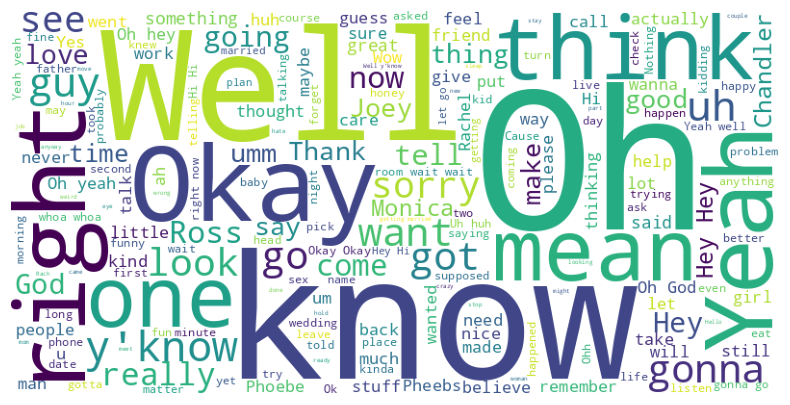

In [9]:
create_wordcloud(df, my_class_index='utterances')


#### Defining same useful variables 

In [10]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
TRIGGERS = np.unique([item for sublist in df["triggers"] for item in sublist])

EMOTIONS_TO_IDX = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
IDX_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

EMOTIONS_TO_IDX


{'anger': 0,
 'disgust': 1,
 'fear': 2,
 'joy': 3,
 'neutral': 4,
 'sadness': 5,
 'surprise': 6}

### Taking a look to same utterance example

In [11]:
display_dialogue(dataframe=df, utterance_id='utterance_3359')
display_dialogue(dataframe=df, utterance_id='utterance_456')
display_dialogue(dataframe=df, utterance_id='utterance_2005')


Utterance 3359


,speakers,emotions,utterances,triggers
0,Ross,neutral,Yes that's right.,0.0
1,The Instructor,surprise,Why?,0.0
2,Ross,neutral,"I tired attacking two women, did not work.",0.0
3,The Instructor,surprise,What?!,0.0
4,Ross,neutral,"No, I mean it's okay, I mean, they're-they're ...",0.0
5,Ross,anger,"In fact, I-I-I was married to one of them.",0.0
6,The Instructor,anger,"Let me get this straight man, you attacked you...",0.0
7,Ross,surprise,"Oh, no!",0.0
8,Ross,surprise,No-no!,0.0
9,Ross,surprise,"No, I tired!",1.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


### Analyzing the dataset

####  Dialogues Statistics

In [12]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in a dialog: {speakers['min_speakers']}")
print(f"Maximum number of speakers in a dialog: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in a dialog: {utterances['length_min']}")
print(f"Maximum number of sentences in a dialog: {utterances['length_max']}")


Number of unique speakers: 231

Minimum number of speakers in a dialog: 1
Maximum number of speakers in a dialog: 8

Minimum number of sentences in a dialog: 2
Maximum number of sentences in a dialog: 24


#### Speaker emotion Distribution 

In [13]:
produce_speaker_emotion_distribution(df)


emotions,anger,disgust,fear,joy,neutral,sadness,surprise
speakers,,,,,,,
Joey,661,149,143,1045,2418,309,841
Ross,541,72,180,967,2280,429,568
Chandler,553,193,203,715,2157,287,560
Rachel,539,146,178,929,1907,566,756
Phoebe,612,117,104,770,1906,409,556
...,...,...,...,...,...,...,...
Another Tour Guide,4,0,0,0,0,0,0
Boy in the Cape,1,0,0,0,0,0,0
Monica and Phoebe,1,0,0,0,0,0,0


### Applying some preprocessing operations 


In [14]:
df['speaker_and_utterances'] = [[speaker[i] + ': ' + utterance[i] for i in range(len(speaker))] for speaker,utterance in zip(df['speakers'],df['utterances'])]


### Splitting the dataset 

In [15]:
train_df, val_df, test_df = split_dataset(df)

print("Training Set: ")
display(train_df)

print("\nValidation Set: ")
display(val_df)

print("\nTest Set: ")
display(test_df)


Training Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_2655,"[Ben, Rachel, Ben, Rachel, Ben, Rachel]","[disgust, fear, joy, fear, joy, anger]","[Oh damnit!, No! Don't say that! Don't say tha...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[Ben: Oh damnit!, Rachel: No! Don't say that! ..."
utterance_3511,"[Rachel, Chandler, Janice, Chandler, Janice, C...","[neutral, sadness, fear, joy, sadness, disgust...","[Okay., Okay, we have to talk. I'm just gettin...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Rachel: Okay., Chandler: Okay, we have to tal..."
utterance_1309,"[Rachel, Phoebe, Rachel]","[neutral, neutral, joy]","[Hey!, Hey!, Oh honey, I'm so sorry, you were ...","[0.0, 0.0, 1.0]","[Rachel: Hey!, Phoebe: Hey!, Rachel: Oh honey,..."
utterance_1333,"[Chandler, Chandler, Chandler, Chandler]","[neutral, anger, joy, anger]","[Yes, Fran., I know what time it is, but I'm l...","[0.0, 0.0, 0.0, 0.0]","[Chandler: Yes, Fran., Chandler: I know what t..."
utterance_1264,"[Ross, Chandler, Monica, Ross, Monica, Monica,...","[surprise, joy, neutral, neutral, surprise, sa...","[....and 12, 22, 18, four... What?, I spelled...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[Ross: ....and 12, 22, 18, four... What?, Cha..."
...,...,...,...,...,...
utterance_3711,"[Joey, Rachel, Rachel, Rachel, Rachel, Joey]","[surprise, surprise, surprise, surprise, joy, ...","[Oh my, oh my God!, Aw, it's unbelievable!, Wo...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[Joey: Oh my, oh my God!, Rachel: Aw, it's unb..."
utterance_1637,"[Phoebe, Rachel, Phoebe, Rachel, Dr. Green, Ra...","[neutral, surprise, sadness, fear, neutral, su...",[I'm sorry I won't be able to make it to your ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[Phoebe: I'm sorry I won't be able to make it ...
utterance_426,"[Monica, Monica, Rachel, Monica, Pete, Monica,...","[surprise, fear, neutral, neutral, neutral, ne...","[And y'know what, I just realised, in the last...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]","[Monica: And y'know what, I just realised, in ..."



Validation Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_2310,"[Kim, Nancy, Rachel, Kim, Rachel, Nancy]","[neutral, joy, joy, neutral, neutral, neutral]","[So, we're decided, no on plaid, yes on pink?,...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[Kim: So, we're decided, no on plaid, yes on p..."
utterance_3572,"[Rachel, Phoebe, Rachel, Phoebe, Rachel, Rache...","[neutral, surprise, neutral, surprise, neutral...","[Do you remember where the duck food is?, Yeah...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...",[Rachel: Do you remember where the duck food i...
utterance_1775,"[Chandler, Joey, Monica, Joey, Monica, Chandle...","[neutral, surprise, joy, neutral, neutral, neu...","[Okay, okay, here she comes! How do I look? D...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Chandler: Okay, okay, here she comes! How do..."
utterance_1153,"[Ross, Monica, Ross, Monica, Ross]","[neutral, joy, sadness, neutral, neutral]","[And why do you care so much?, Because! You co...","[0.0, 1.0, 0.0, 1.0, 0.0]","[Ross: And why do you care so much?, Monica: B..."
utterance_1985,"[Rachel, Ross, Ross, Rachel, Ross, Ross, Ross,...","[anger, neutral, neutral, anger, neutral, neut...",[Ross! I think she is trying to make something...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",[Rachel: Ross! I think she is trying to make s...
...,...,...,...,...,...
utterance_599,"[Singer, Joey, Phoebe, Chandler, Phoebe, Chand...","[joy, surprise, anger, neutral, neutral, neutr...","[Cause every time I see your face, I can't he...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Singer: Cause every time I see your face, I ..."
utterance_362,"[Ross, Ross, Ross, Ross]","[neutral, neutral, neutral, fear]","[Th-th-that's all it is, a third nipple., Just...","[0.0, 0.0, 0.0, 1.0]","[Ross: Th-th-that's all it is, a third nipple...."
utterance_1317,"[Monica, Phoebe, Ross, Monica]","[joy, joy, joy, neutral]","[Hey!, Hey!, Hi!, So, do you guys wanna come a...","[0.0, 0.0, 0.0, 1.0]","[Monica: Hey!, Phoebe: Hey!, Ross: Hi!, Monica..."



Test Set: 


,speakers,emotions,utterances,triggers,speaker_and_utterances
index,,,,,
utterance_2186,"[Ross, Mrs. Geller, Ross, Mrs. Geller, Ross, M...","[joy, neutral, joy, neutral, neutral, neutral,...","[Hi! I'm so glad you're here, but it's gonna b...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]","[Ross: Hi! I'm so glad you're here, but it's g..."
utterance_806,"[Phoebe, Rachel, Monica, Phoebe]","[neutral, joy, neutral, sadness]","[Hi, guys., Hi! Phoebe., Hi Phoebe., I-I wante...","[0.0, 0.0, 0.0, 1.0]","[Phoebe: Hi, guys., Rachel: Hi! Phoebe., Monic..."
utterance_1762,"[Ross, Monica, Ross, Monica]","[neutral, neutral, neutral, fear]","[Hey! How long until Pete's fight?, Oh, about ...","[0.0, 1.0, 0.0, 1.0]","[Ross: Hey! How long until Pete's fight?, Moni..."
utterance_1102,"[Monica, Ross, Ross]","[anger, anger, joy]","[Let go!, No! You let go!, How come it's alway...","[0.0, 0.0, 0.0]","[Monica: Let go!, Ross: No! You let go!, Ross:..."
utterance_1428,"[Joey, Phoebe, Joey, Phoebe]","[joy, joy, joy, fear]","[Hey Pheebs!, Hey!, Check it out. How much of...","[0.0, 0.0, 0.0, 0.0]","[Joey: Hey Pheebs!, Phoebe: Hey!, Joey: Check ..."
...,...,...,...,...,...
utterance_2953,"[Rachel, Joey, Rachel, Joey, Rachel, Joey, Rac...","[joy, joy, neutral, joy, joy, surprise, disgus...","[Hi!, Hey!, Joey, I gotta tell ya, I've been t...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[Rachel: Hi!, Joey: Hey!, Rachel: Joey, I gott..."
utterance_175,"[Chandler, Joey, Joey, Joey, Joey, Joey, Joey,...","[neutral, neutral, neutral, neutral, neutral, ...","[You know, I don't think we brought enough stu...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]","[Chandler: You know, I don't think we brought ..."
utterance_2041,"[Monica, Joey, Monica]","[sadness, surprise, disgust]","[Oh, god help us., What?, Ugly Naked Guy's lay...","[0.0, 1.0, 0.0]","[Monica: Oh, god help us., Joey: What?, Monica..."


### Visualizing the classes distribution over the datasets

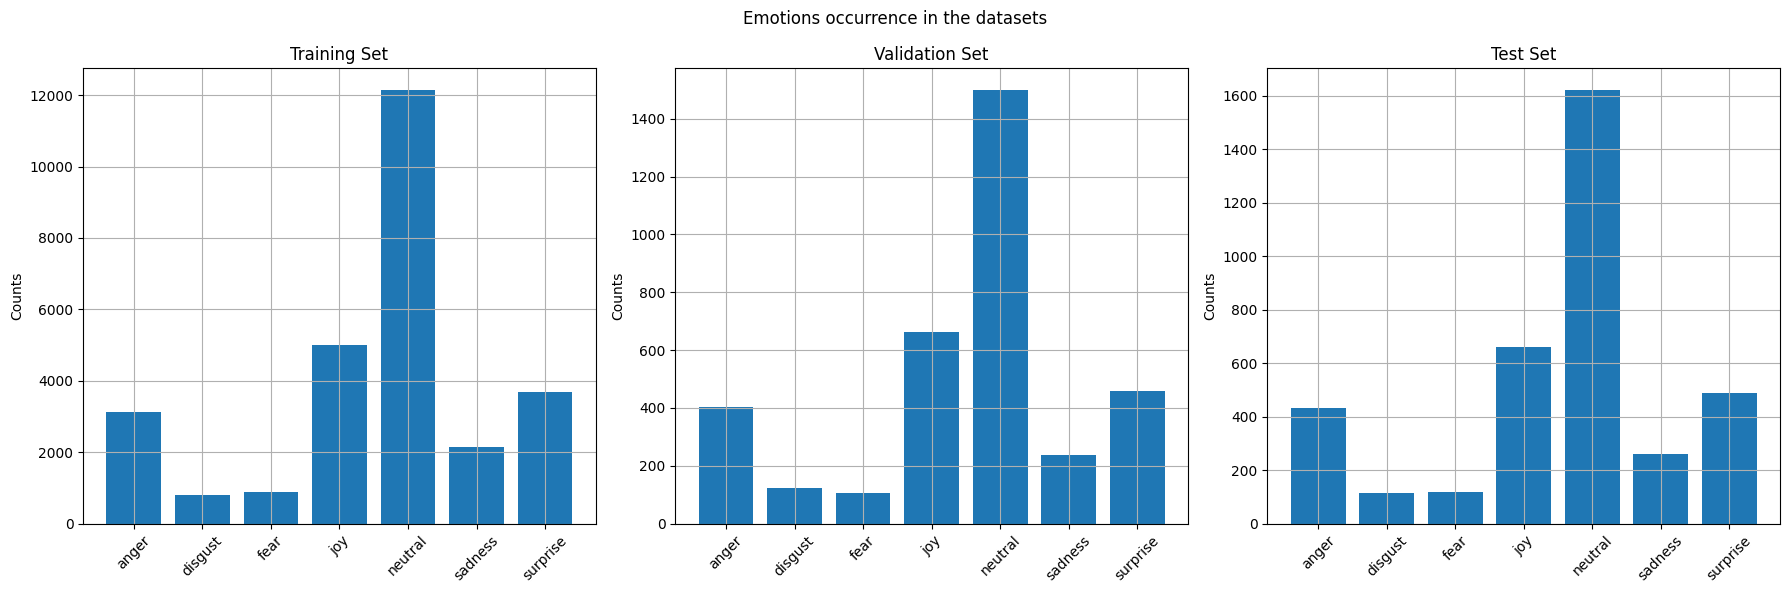

In [16]:
plot_emotion_distribution(train_df, val_df, test_df)


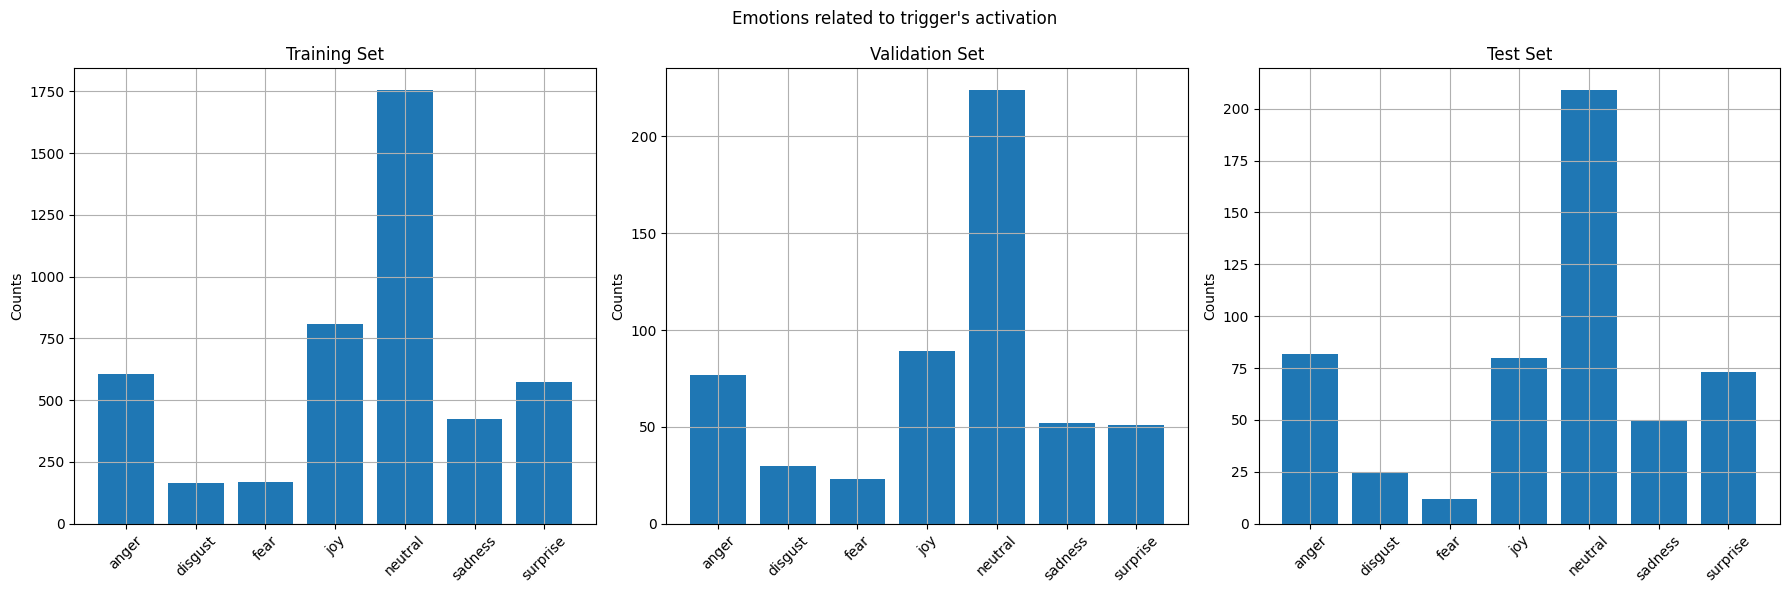

In [17]:
# How many times each emotion activates a trigger    #todo spiegare meglio 
plot_triggers_per_emotion(train_df, val_df, test_df)


### Computing the class weighs 

As we observed, the classes distribution is unbalanced, hence, it may be useful to define a weight policy to determine the importance of each
class in the computation of the loss function. This importance value is a dynamic trainable parameter of the model that changes along the training
process

$$
w_i = \frac{N}{K \cdot N_i}
$$


Here:
- $N$: is the total number of samples;
- $K$: is the number of classes;
- $N_i$: is a sample of class $i$; 


In [18]:
emotion_weights = create_classes_weights([EMOTIONS_TO_IDX[emotion]for emotion in df['emotions'].sum()])
emotion_weights = np.append(emotion_weights, 0)

trigger_weights = create_classes_weights(df['triggers'].sum())
trigger_weights = np.append(trigger_weights, 0)

padded_emotions = list(EMOTIONS) + ['z_emotion']    
padded_triggers = list(TRIGGERS) + [2]

print('Emotion weights')
display(pd.DataFrame({'Emotion': padded_emotions, 'Weight': emotion_weights}))

print('Trigger weights')
display(pd.DataFrame({'Trigger': padded_triggers, 'Weight': trigger_weights}))


Emotion weights


,Emotion,Weight
0,anger,1.261352
1,disgust,4.766444
2,fear,4.488330
3,joy,0.791515
4,neutral,0.327590
5,sadness,1.888218
6,surprise,1.076426
7,z_emotion,0.000000


Trigger weights


,Trigger,Weight
0,0.0,0.594732
1,1.0,3.139013
2,2.0,0.000000


## Random Classifier

In [19]:
# todo metric computation
if RUN_RANDOM_CLF:
    
    emotion_f1 = F1_Score(name='emotion_F1',
                      mode='macro',
                      num_classes=len(EMOTIONS),
                      pred_transform=lambda x: x,
                      target_transform=lambda x: x)     

    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(TRIGGERS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     


    random_classifier = RandomClassifier(EMOTIONS)
    pred_emotions, pred_triggers = random_classifier.predict(test_df)
        
    random_clf_results_df = test_df.copy()
    random_clf_results_df['pred_emotions'] = pred_emotions
    random_clf_results_df['pred_triggers'] = pred_triggers
    
    unrolled_emotion_f1, unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1, trigger_f1, random_clf_results_df, EMOTIONS_TO_IDX)
    f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1, trigger_f1, random_clf_results_df, EMOTIONS_TO_IDX)
    

    print('Random Classifier results\n')
    print(f'{"Metric":<30} {"Score"}')
    print(f'{"Unrolled emotions f1 scores":<30} {unrolled_emotion_f1}')
    print(f'{"Unrolled triggers f1 scores":<30} {unrolled_triggers_f1}')
    
    print(f'{"AVG emotion f1 score":<30} {f1_per_dialogue_df["Emotion_f1"].mean()}')
    print(f'{"AVG triggers f1 score":<30} {f1_per_dialogue_df["Trigger_f1"].mean()}\n')
    
    print('F1 scores for each dialogue:')
    display(f1_per_dialogue_df)
    
    difficult_dialogue_index = f1_per_dialogue_df.sort_values(by=['Emotion_f1', 'Trigger_f1']).iloc[0].name 
    
    print('Focus on a dialogue with low f1 scores:')
    display_dialogue(dataframe=random_clf_results_df.drop(columns='speaker_and_utterances'), utterance_id=difficult_dialogue_index)      


Random Classifier results

Metric                         Score
Unrolled emotions f1 scores    0.12421594461047063
Unrolled triggers f1 scores    0.42532973524715967
AVG emotion f1 score           0.0747734053810458
AVG triggers f1 score          0.40586778548937985

F1 scores for each dialogue:


,Emotion_f1,Trigger_f1
utterance_2186,0.000000,0.222222
utterance_806,0.095238,1.000000
utterance_1762,0.114286,0.200000
utterance_1102,0.000000,0.000000
utterance_1428,0.000000,0.428571
...,...,...
utterance_2953,0.193197,0.291667
utterance_175,0.000000,0.750000
utterance_2041,0.095238,0.666667
utterance_2127,0.057143,0.360000


Focus on a dialogue with low f1 scores:
Utterance 1102


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Monica,anger,Let go!,0.0,fear,1.0
1,Ross,anger,No! You let go!,0.0,joy,1.0
2,Ross,joy,How come it's always us left in the field hold...,0.0,disgust,1.0


## Majority Classifier

In [20]:
# todo metrics computation
if RUN_MAJORITY_CLF:
    
    emotion_f1 = F1_Score(name='emotion_F1',
                      mode='macro',
                      num_classes=len(EMOTIONS),
                      pred_transform=lambda x: x,
                      target_transform=lambda x: x)     

    trigger_f1 = F1_Score(name='triggers_F1',
                          mode='macro',
                          num_classes=len(TRIGGERS),
                          pred_transform=lambda x: x,
                          target_transform=lambda x: x)     
    
    
    majority_classifier = MajorityClassifier()
    majority_classifier.fit(train_df)
    pred_emotions, pred_triggers = majority_classifier.predict(test_df)
    
    majority_clf_results_df = test_df.copy()
    majority_clf_results_df['pred_emotions'] = pred_emotions
    majority_clf_results_df['pred_triggers'] = pred_triggers
    
    
    unrolled_emotion_f1, unrolled_triggers_f1 = compute_unrolled_f1(emotion_f1, trigger_f1, majority_clf_results_df, EMOTIONS_TO_IDX)
    f1_per_dialogue_df = compute_f1_per_dialogues(emotion_f1, trigger_f1, majority_clf_results_df, EMOTIONS_TO_IDX)
    
    print('Majority Classifier results\n')
    print(f'{"Metric":<30} {"Score"}')
    print(f'{"Unrolled emotions f1 scores":<30} {unrolled_emotion_f1}')
    print(f'{"Unrolled triggers f1 scores":<30} {unrolled_triggers_f1}')
    
    print(f'{"AVG emotion f1 score":<30} {f1_per_dialogue_df["Emotion_f1"].mean()}')
    print(f'{"AVG triggers f1 score":<30} {f1_per_dialogue_df["Trigger_f1"].mean()}\n')
    
    print('F1 scores for each dialogue:')
    display(f1_per_dialogue_df)
    
    difficult_dialogue_index = f1_per_dialogue_df.sort_values(by=['Emotion_f1', 'Trigger_f1']).iloc[0].name 
    
    print('Focus on a dialogue with low f1 scores:')
    display_dialogue(dataframe=majority_clf_results_df.drop(columns='speaker_and_utterances'), utterance_id=difficult_dialogue_index)      
        


Majority Classifier results

Metric                         Score
Unrolled emotions f1 scores    0.0871761797269698
Unrolled triggers f1 scores    0.4612804433425696
AVG emotion f1 score           0.08080883187025725
AVG triggers f1 score          0.4439985811577781

F1 scores for each dialogue:


,Emotion_f1,Trigger_f1
utterance_2186,0.103896,0.461538
utterance_806,0.095238,0.428571
utterance_1762,0.122449,0.333333
utterance_1102,0.000000,0.500000
utterance_1428,0.000000,0.500000
...,...,...
utterance_2953,0.042857,0.392857
utterance_175,0.133333,0.333333
utterance_2041,0.000000,0.400000
utterance_2127,0.077922,0.500000


Focus on a dialogue with low f1 scores:
Utterance 3120


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Woman,anger,"Comin' through. Move, move.",1.0,neutral,0.0
1,Rachel,joy,"Oh, 'scuse me. I was kinda using that machine.",0.0,neutral,0.0
2,Woman,disgust,"Yeah, well, now you're kinda not.",1.0,neutral,0.0
3,Rachel,anger,But I saved it. I put my basket on top.,1.0,neutral,0.0
4,Woman,anger,"Oh, I'm sorry, is that your basket? It's reall...",1.0,neutral,0.0
5,Rachel,surprise,What?,0.0,neutral,0.0


## Bert Models

In [21]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY)


#### Data Loaders creation

In [41]:
dataLoaderBuilder = DataLoaderFromPipelineStrategy()

max_tokenized_length =  find_max_encoded_utterance(bert_tokenizer, df['utterances'])

my_tokenization_f = partial(tokenize_data, max_tokenized_length=max_tokenized_length,tokenizer=bert_tokenizer)


# BertFreezed Dataloaders
train_dataloader_freezed = dataLoaderBuilder.create(data=train_df["utterances"],
                                                    labels=train_df[["emotions", "triggers"]],
                                                    shuffle=True,
                                                    data_preprocess_f=my_tokenization_f,
                                                    labels_preprocess_f=preprocess_labels,
                                                    batch_size=BATCH_SIZE_FREEZED,
                                                    device=device)
 
val_dataloader_freezed = dataLoaderBuilder.create(data=val_df["utterances"],
                                                  labels=val_df[["emotions", "triggers"]],
                                                  shuffle=False,
                                                  data_preprocess_f=my_tokenization_f,
                                                  labels_preprocess_f=preprocess_labels,
                                                  batch_size=BATCH_SIZE_FREEZED,
                                                  device=device)
 
test_dataloader_freezed = dataLoaderBuilder.create(data=test_df["utterances"],
                                                   labels=test_df[["emotions", "triggers"]],
                                                   shuffle=False,
                                                   data_preprocess_f=my_tokenization_f,
                                                   labels_preprocess_f=preprocess_labels,
                                                   batch_size=BATCH_SIZE_FREEZED,
                                                   device=device)   


# BertFull Dataloaders
train_dataloader_full = dataLoaderBuilder.create(data=train_df["utterances"],
                                                 labels=train_df[["emotions", "triggers"]],
                                                 shuffle=True,
                                                 data_preprocess_f=my_tokenization_f,
                                                 labels_preprocess_f=preprocess_labels,
                                                 batch_size=BATCH_SIZE_FULL,
                                                 device=device)

val_dataloader_full = dataLoaderBuilder.create(data=val_df["utterances"],
                                               labels=val_df[["emotions", "triggers"]],
                                               shuffle=False,
                                               data_preprocess_f=my_tokenization_f,
                                               labels_preprocess_f=preprocess_labels,
                                               batch_size=BATCH_SIZE_FULL,
                                               device=device)

test_dataloader_full = dataLoaderBuilder.create(data=test_df["utterances"],
                                                labels=test_df[["emotions", "triggers"]],
                                                shuffle=False,
                                                data_preprocess_f=my_tokenization_f,
                                                labels_preprocess_f=preprocess_labels,
                                                batch_size=BATCH_SIZE_FULL,
                                                device=device)  
 
input_data_freezed, _ = next(iter(train_dataloader_freezed))
input_data_full, _ = next(iter(train_dataloader_full))

n_token_per_utterance = input_data_freezed['input_ids'].shape[-1]


In [42]:
next(iter(test_dataloader_freezed))[0]['input_ids'].shape


torch.Size([16, 24, 95])

In [43]:
next(iter(test_dataloader_freezed))[1]['emotions'].shape

torch.Size([16, 24, 8])

### Defining Metrics and Criterion

In [50]:
##### Losses definitions and combination
emotion_weight_criterion = 1
trigger_weight_criterion = 1

emotion_criterion = Criterion(name='emotion_cross_entropy', 
                              loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(emotion_weights, device=device)))  # weight=torch.tensor(emotion_weights)

trigger_criterion = Criterion(name='trigger_cross_entropy', 
                              loss_function=torch.nn.CrossEntropyLoss(reduction='none', weight=torch.tensor(trigger_weights, device=device)))  # weight=torch.tensor(trigger_weights)

multi_head_criterion = MultyHeadCriterion(name='agg_CE_loss',
                                          loss_functions={'emotions': emotion_criterion, 
                                                          'triggers': trigger_criterion},
                                          loss_weights=[emotion_weight_criterion, trigger_weight_criterion],
                                          reduction_function=torch.mean) #torch.sum TESTA


##### Metrics definitions and combination

# F1 definition
emotion_weight_metrics = 1
trigger_weight_metrics = 1

emotion_f1 = F1_Score(name='emotion_F1',
                      mode='macro',
                      num_classes=len(padded_emotions),
                      classes_to_exclude=[8])     

trigger_f1 = F1_Score(name='triggers_F1',
                      mode='macro',
                      num_classes=len(padded_triggers),
                      classes_to_exclude=[2])     

multi_head_f1 = MultyHeadMetric(name='agg_avg_F1',
                                metrics_functions={'emotions': emotion_f1,
                                                   'triggers': trigger_f1},
                                metric_weights=[emotion_weight_metrics, trigger_weight_metrics],
                                aggregate_metrics_function=torch.mean)


# Accuracy definition
emotion_accuracy = Accuracy(name='emotion_accuracy',
                            num_classes=len(padded_emotions),
                            classes_to_exclude=[8])     

trigger_accuracy = Accuracy(name='triggers_accuracy',
                            num_classes=len(padded_triggers),
                            classes_to_exclude=[2])     

multi_head_accuracy = MultyHeadMetric(name='agg_avg_accuracy',
                                      metrics_functions={'emotions': emotion_accuracy,
                                                         'triggers': trigger_accuracy},
                                      metric_weights=[emotion_weight_metrics, trigger_weight_metrics],
                                      aggregate_metrics_function=torch.mean)


# Recall definition
emotion_recall = Recall(name='emotion_recall',
                        num_classes=len(padded_emotions),
                        classes_to_exclude=[8])     

trigger_recall = Recall(name='triggers_recall',
                        num_classes=len(padded_triggers),
                        classes_to_exclude=[2])     

multi_head_recall = MultyHeadMetric(name='agg_avg_recall',
                                    metrics_functions={'emotions': emotion_recall,
                                                       'triggers': trigger_recall},
                                    metric_weights=[emotion_weight_metrics, trigger_weight_metrics],
                                    aggregate_metrics_function=torch.mean)


# Precision definition
emotion_precision = Precision(name='emotion_precision',
                              num_classes=len(padded_emotions),
                              classes_to_exclude=[8])     

trigger_precision = Precision(name='triggers_precision',
                              num_classes=len(padded_triggers),
                              classes_to_exclude=[2])     
      
multi_head_precision = MultyHeadMetric(name='agg_avg_precision',
                                       metrics_functions={'emotions': emotion_precision,
                                                          'triggers': trigger_precision},
                                       metric_weights=[emotion_weight_metrics, trigger_weight_metrics],
                                       aggregate_metrics_function=torch.mean)
   

##### Defining Optimizer and early stopper

optimizer = OptimizerWrapper(optimizer_constructor=torch.optim.Adam,
                             identifier=f'lr={1e-5}', 
                             optimizer_partial_params={'lr': 1e-5})  

early_stopper = EarlyStopper(monitor='agg_avg_F1',
                             patience=PATIENCE, 
                             delta=0, 
                             mode='max',
                             restore_weights=True)
        

### Freezed Bert

#### Grid Search Freezed BertOne 

In [25]:
# DataLoaderFromPipelineStrategy.create() unpacking parameter logic
def my_logic(param, _):
        if param == 'data_preprocess_f':
            max_tokenized_length = find_max_encoded_utterance(bert_tokenizer, df['utterances'])
            additional_parm  = partial(tokenize_data, max_tokenized_length=max_tokenized_length, tokenizer=bert_tokenizer)
        elif param == 'labels_preprocess_f':
            additional_parm = preprocess_labels
        elif param == 'pin_memory':
            additional_parm = True
        elif param == 'num_workers':
            additional_parm = 10
        elif param == 'sample_preprocess_f':
            additional_parm = None
        elif param == 'label_preprocess_f':
            additional_parm = None
        else:
            raise AttributeError (f"DataLoaderFromPipelineStrategy.create() require attribute {param}")
        return additional_parm


if RUN_FREEZED_BERT_GRID_SEARCH:

    hyperparameters_key_to_save = ['criterion']
    optimizers = [OptimizerWrapper(torch.optim.Adam, identifier=f'lr={2*(10**(-5))}', optimizer_partial_params={'lr':2*(10**(-5))})]

    emotion_criterion = Criterion(name='emotion_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'))

    trigger_criterion = Criterion(name='trigger_cross_entropy',
                                  loss_function=torch.nn.CrossEntropyLoss(reduction='none'))

    balanced_multi_head_criterion = MultyHeadCriterion(name='balanced_CE_loss',
                                                       loss_functions={'emotions': emotion_criterion,
                                                                       'triggers': trigger_criterion},
                                                       loss_weights=[1, 1],
                                                       reduction_function=torch.mean)

    unbalanced_multi_head_criterion_1 = MultyHeadCriterion(name='CE_loss_unbalanced_toward_emotions',
                                                           loss_functions={'emotions': emotion_criterion,
                                                                           'triggers': trigger_criterion},
                                                           loss_weights=[1, 0.5],
                                                           reduction_function=torch.mean)

    unbalanced_multi_head_criterion_2 = MultyHeadCriterion(name='CE_loss_unbalanced_toward_triggers',
                                                           loss_functions={'emotions': emotion_criterion,
                                                                           'triggers': trigger_criterion},
                                                           loss_weights=[0.5, 1],
                                                           reduction_function=torch.mean)

    criteria = [balanced_multi_head_criterion, unbalanced_multi_head_criterion_1, unbalanced_multi_head_criterion_2]
    criteria_and_early_stoppers = []
    for criterion in criteria:
        new_early_stopper = EarlyStopper(monitor=criterion.name, patience=3, delta=0.005, mode='min', restore_weights=True)
        criteria_and_early_stoppers.append((criterion, early_stopper))


    model_hyperparameters_to_test=[{'model_class':BertOne,
                                    'bert_model':bert_model,
                                    'n_emotions':len(padded_emotions),
                                    'n_triggers':len(padded_triggers),
                                    'cls_input_size':n_token_per_utterance * BERT_HIDDEN_DIM,
                                    'freeze_bert_weights':True}]

    training_hyperparameters_to_test = [{'num_epochs': 50,
                                         'optimizer': optimizer,
                                         'batch_size': 32,
                                         'criterion': criterion_and_early_stopper[0],
                                         'early_stopper': criterion_and_early_stopper[1],
                                         'interaction_with_wandb': False,
                                         #interaction_function_with_wandb todo
                                         }for optimizer, criterion_and_early_stopper in itertools.product(optimizers, criteria_and_early_stoppers)]


    dataLoaderBuilder = DataLoaderFromPipelineStrategy(logic=partial(my_logic))


    grid_result_df = grid_search_train_validation(train_data=(train_df["utterances"], train_df[["emotions", "triggers"]]),
                                                  val_data=(val_df["utterances"], val_df[["emotions", "triggers"]]),
                                                  dataloader_builder=dataLoaderBuilder,
                                                  shuffle=True,
                                                  model_hyperparameters_to_test=model_hyperparameters_to_test,
                                                  training_hyperparameters_to_test=training_hyperparameters_to_test,
                                                  hyperparameters_key_to_save=hyperparameters_key_to_save,
                                                  device=device,
                                                  path_to_grid_search_results=FREEZED_BERTONE_GRID_SEARCH_RESULTS_PATH,
                                                  seeds=[42],   #todo add 4 seeds
                                                  save_loss_values=True,
                                                  #wandb_params=wandb_params)  #todo insert name project and team name
                                                  )



#### Creating Freezed BertOne

In [45]:
torch.manual_seed(42)
np.random.seed(42)

freezed_bert = BertOne(bert_model=bert_model,
                       n_emotions=len(padded_emotions),
                       n_triggers=len(padded_triggers),
                       cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                       freeze_bert_weights=True).to(device)



####   Visualizing Net Structure 

In [46]:
freezed_bert.visualize_network_graph(input=input_data_freezed, 
                                     input_names=['tokenized utterances', 'token id', 'attention mask'],
                                     output_names=['emotions,triggers'])


#### Visualizing the summary 

In [28]:
freezed_bert.summary(input_data_freezed, verbose=True)


--------------------------------------------------------------------
             Layer (type)               Output Shape         Param #
              Embedding-1             [16, 380, 768]      23,440,896
              Embedding-2             [16, 380, 768]           1,536
              Embedding-3             [16, 380, 768]         393,216
              LayerNorm-4             [16, 380, 768]           1,536
                Dropout-5             [16, 380, 768]               0
         BertEmbeddings-6             [16, 380, 768]               0
                 Linear-7             [16, 380, 768]         590,592
                 Linear-8             [16, 380, 768]         590,592
                 Linear-9             [16, 380, 768]         590,592
               Dropout-10         [16, 12, 380, 380]               0
     BertSelfAttention-11           [[-1, 380, 768]]               0
                Linear-12             [16, 380, 768]         590,592
               Dropout-13         

#### Fitting Freezed BertOne

In [ ]:
if FIT_FREEZED_BERTONE:

    freezed_bert_history = freezed_bert.fit(train_loader=train_dataloader_freezed,
                                            val_loader=val_dataloader_freezed,
                                            criterion=multi_head_criterion,
                                            metrics=[multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                            optimizer=optimizer,
                                            early_stopper=early_stopper,
                                            verbose = 2,
                                            num_epochs=25)

    torch.save(freezed_bert.state_dict(), FREEZED_BERTONE_WEIGHTS_PATH)

else:
    freezed_bert.load_state_dict(torch.load(FREEZED_BERTONE_WEIGHTS_PATH))
    freezed_bert_history = None



Epoch 1/25                                          Time: 608.5878s
Metric/Loss                 Training                 Validation               
--------------------------------------------------------------------
Agg_ce_loss                 0.4913152722             0.5161404387             
Agg_avg_f1                  0.3373727399             0.3291353756             
Emotion_f1                  0.3382690133             0.3222417106             
Triggers_f1                 0.3364764664             0.3360290407             
Agg_avg_accuracy            0.2588980672             0.2554447472             
Emotion_accuracy            0.1853255208             0.1816666667             
Triggers_accuracy           0.3324706136             0.3292228276             
Agg_avg_recall              0.2519365891             0.2462318179             
Emotion_recall              0.3094514364             0.2981905737             
Triggers_recall             0.1944217417             0.1942730622        

#### Visualizing training history  

In [ ]:
if FIT_FREEZED_BERTONE:
    plot_history(freezed_bert_history, patience=PATIENCE)
else:
    print("To show the training history of Freezed BERT base model  you should set the flag FIT_FREEZED_BERTONE=True ")
    

### Full Bert

#### Grid Search Full BertOne 

In [ ]:
# todo grid search

#### Creating Full BertOne

In [ ]:
full_bert = BertOne(bert_model=bert_model,
                    n_emotions=len(padded_emotions),
                    n_triggers=len(padded_triggers),
                    cls_input_size=n_token_per_utterance * BERT_HIDDEN_DIM,
                    freeze_bert_weights=False).to(device)

#### Visualizing the summary 

In [ ]:
full_bert.summary(input_data_full, verbose=True)


#### Fitting Freezed BertOne

In [ ]:
if FIT_FULL_BERTONE:

    full_bert_history = full_bert.fit(train_loader=train_dataloader_full,
                                      val_loader=val_dataloader_full,
                                      criterion=multi_head_criterion,
                                      metrics=[multi_head_f1, multi_head_accuracy, multi_head_recall, multi_head_precision],
                                      optimizer=optimizer,
                                      early_stopper=early_stopper,
                                      num_epochs=25)
        
    torch.save(full_bert.state_dict(), FULL_BERTONE_WEIGHTS_PATH)

else:
    full_bert.load_state_dict(torch.load(FULL_BERTONE_WEIGHTS_PATH))
    full_bert_history = None


#### Visualizing training history  

In [ ]:
if FIT_FULL_BERTONE:
    plot_history(full_bert_history, patience=PATIENCE)
else:
    print("To show the training history of Full BERT base model  you should set the flag FIT_FULL_BERTONE=True ")

## Further experiments

### Dataloaders creation

In [ ]:
max_tokenized_length_su = find_max_encoded_utterance(bert_tokenizer, df['speaker_and_utterances'])
my_tokenization_f_su = partial(tokenize_data, max_tokenized_length=max_tokenized_length_su, tokenizer=bert_tokenizer)

# BertFreezed Dataloaders
train_dataloader_freezed_su = dataLoaderBuilder.create(data=train_df["speaker_and_utterances"],
                                                       labels=train_df[["emotions", "triggers"]],
                                                       shuffle=True,
                                                       data_preprocess_f=my_tokenization_f_su,
                                                       labels_preprocess_f=preprocess_labels,
                                                       batch_size=32,
                                                       device=device)
 
val_dataloader_freezed_su = dataLoaderBuilder.create(data=val_df["speaker_and_utterances"],
                                                     labels=val_df[["emotions", "triggers"]],
                                                     shuffle=False,
                                                     data_preprocess_f=my_tokenization_f_su,
                                                     labels_preprocess_f=preprocess_labels,
                                                     batch_size=32,
                                                     device=device)
 
test_dataloader_freezed_su = dataLoaderBuilder.create(data=test_df["speaker_and_utterances"],
                                                      labels=test_df[["emotions", "triggers"]],
                                                      shuffle=False,
                                                      data_preprocess_f=my_tokenization_f_su,
                                                      labels_preprocess_f=preprocess_labels,
                                                      batch_size=32,
                                                      device=device)


# BertFull Dataloaders
train_dataloader_full_su = dataLoaderBuilder.create(data=train_df["speaker_and_utterances"],
                                                    labels=train_df[["emotions", "triggers"]],
                                                    shuffle=True,
                                                    data_preprocess_f=my_tokenization_f_su,
                                                    labels_preprocess_f=preprocess_labels,
                                                    batch_size=2,
                                                    device=device)
 
val_dataloader_full_su = dataLoaderBuilder.create(data=val_df["speaker_and_utterances"],
                                                  labels=val_df[["emotions", "triggers"]],
                                                  shuffle=False,
                                                  data_preprocess_f=my_tokenization_f_su,
                                                  labels_preprocess_f=preprocess_labels,
                                                  batch_size=2,
                                                  device=device)
 
test_dataloader_full_su = dataLoaderBuilder.create(data=test_df["speaker_and_utterances"],
                                                   labels=test_df[["emotions", "triggers"]],
                                                   shuffle=False,
                                                   data_preprocess_f=my_tokenization_f_su,
                                                   labels_preprocess_f=preprocess_labels,
                                                   batch_size=2,
                                                   device=device)


input_data_freezed_su, _ = next(iter(train_dataloader_freezed_su))
input_data_full_su, _ = next(iter(train_dataloader_full_su))

n_token_per_utterance_su = input_data_freezed_su['input_ids'].shape[-1]

In [ ]:
# todo inserire i test aggiungendo gli speaker
# todo aggiungere i test mettendo i linear layer aggiuntivi
# todo aggiungere tutti i test del mondo